In [12]:
import pandas as pd

df = pd.read_pickle('../data/data_v1.pkl')
df.head()

,ID,SAMPLETIME,DELTA,READING,DATE,TIME
0,0,2019-02-01 00:39:36,0.0,331710.0,2019-02-01,00:39:36
1,0,2019-02-01 01:39:36,0.0,331710.0,2019-02-01,01:39:36
2,0,2019-02-01 02:39:35,0.0,331710.0,2019-02-01,02:39:35
3,0,2019-02-01 03:39:35,0.0,331710.0,2019-02-01,03:39:35
4,0,2019-02-01 04:39:35,0.0,331710.0,2019-02-01,04:39:35


Para ver si un contador es bueno tiene que tener:

- 24*365-1 entradas (una por cada hora del año)
- Reading tiene que ser creciente
- Reading.diff() y delta tienen que coincidir

In [84]:
def entradas_buenas(df_i):
    return len(df_i) == 24*365-1

In [85]:
def reading_creciente(df_i):
    serie_dif = df_i['READING'].diff().fillna(0) >= 0
    return serie_dif.values.sum() == len(df_i)

In [86]:
def delta_equals_reading_dif(df_i):
    return df_i['DELTA'].equals(df_i['READING'].diff().fillna(0).round(4))

In [97]:
from tqdm import tqdm

dict_contadores = {'contadores_perfectos': [],
                   'not_d_eq_rdif': [],
                   'raros_r_crec_d_eq_rdif':[],
                   'not_entradas_buenas_solo':[],
                   'only_entradas_buenas':[],
                   'only_reading_creciente':[],
                   'only_d_eq_rdif':[],
                   'todo_mal':[]
                  }
for i in tqdm(df['ID'].unique()):
    df_i = df[df['ID']==i]
    if (entradas_buenas(df_i) 
        and reading_creciente(df_i) 
        and delta_equals_reading_dif(df_i)):
        dict_contadores['contadores_perfectos'].append(i)
    elif (entradas_buenas(df_i) 
        and reading_creciente(df_i) 
        and not delta_equals_reading_dif(df_i)):
        dict_contadores['not_d_eq_rdif'].append(i)
    elif (entradas_buenas(df_i) 
        and not reading_creciente(df_i) 
        and delta_equals_reading_dif(df_i)):
        dict_contadores['raros_r_crec_d_eq_rdif'].append(i)
    elif (not entradas_buenas(df_i) 
        and reading_creciente(df_i) 
        and delta_equals_reading_dif(df_i)):
        dict_contadores['not_entradas_buenas_solo'].append(i)
    elif (entradas_buenas(df_i) 
        and not reading_creciente(df_i) 
        and not delta_equals_reading_dif(df_i)):
        dict_contadores['only_entradas_buenas'].append(i)   
    elif (not entradas_buenas(df_i) 
        and reading_creciente(df_i) 
        and not delta_equals_reading_dif(df_i)):
        dict_contadores['only_reading_creciente'].append(i)
    elif (not entradas_buenas(df_i) 
        and not reading_creciente(df_i) 
        and delta_equals_reading_dif(df_i)):
        dict_contadores['only_d_eq_rdif'].append(i)
    elif (not entradas_buenas(df_i) 
        and not reading_creciente(df_i) 
        and not delta_equals_reading_dif(df_i)):
        dict_contadores['todo_mal'].append(i)

100%|██████████████████████████████████████████████████████████████████████████████| 2747/2747 [01:10<00:00, 38.80it/s]


In [99]:
for i in dict_contadores:
    print(i, len(dict_contadores[i]))

contadores_perfectos 57
not_d_eq_rdif 1385
raros_r_crec_d_eq_rdif 1
not_entradas_buenas_solo 56
only_entradas_buenas 527
only_reading_creciente 489
only_d_eq_rdif 0
todo_mal 232


### Análisis y posibles soluciones ```not_d_eq_rdif```

Estos contadores casi bien. Dos opciones para que todo quede bien:

- Quedarse con delta
- Quedarse con reading.diff()

In [115]:
bondad_contadores = {}
for contador in tqdm(dict_contadores['not_d_eq_rdif']):
    rdif0 = df[df['ID']==contador]['READING'].diff().fillna(0).round(4)
    delta0 = df[df['ID']==contador]['DELTA']
    errores = 0
    for (i, (rdif, delta)) in enumerate(zip(rdif0, delta0)):
        if rdif!=delta:
            errores += 1
    bondad_contadores[contador] = errores/len(delta0)

100%|██████████████████████████████████████████████████████████████████████████████| 1385/1385 [01:09<00:00, 19.90it/s]


In [124]:
error_rate = pd.Series(bondad_contadores)
incomplete_clasif = {}
incomplete_clasif['0-5% missing data'] = len(error_rate[error_rate <= 0.05])
incomplete_clasif['5-10% missing data'] = len(error_rate[(error_rate > 0.05) & (error_rate <= 0.1)])
incomplete_clasif['10-15% missing data'] = len(error_rate[(error_rate > 0.1) & (error_rate <= 0.15)])
incomplete_clasif['15-100% missing data'] = len(error_rate[error_rate > 0.15])
incomplete_clasif = pd.Series(incomplete_clasif)
incomplete_clasif

0-5% missing data       1016
5-10% missing data       221
10-15% missing data      116
15-100% missing data      32
dtype: int64

<AxesSubplot:>

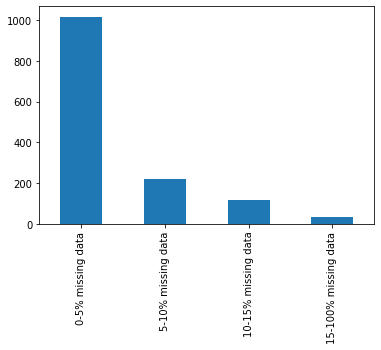

In [125]:
incomplete_clasif.plot(kind='bar')

### Análisis y posibles soluciones ```not_entradas_buenas_solo```

En general son contadores muy malos a los que les faltan muchas entradas. No obstante hay algunos que se libran y si que tienen más del 70% de entradas.

- La mayoría de contadores son todo ceros y las medidas READING son todas iguales: Aquí la solución más viable parece ser poner todos los delta a 0 y a funcionar. 
- Hay algunos contadores que sí tienen medidas y justo en los últimos días de Enero de 2020 (que es cuando hay que empezar a predecir). Para esos igual es interesante utilizar alguna estrategia (ver contador 2736).

In [143]:
#contadores cuyos todos deltas son 0 y cuyos todos reading son iguales
todo_ceros = []
for i in tqdm(dict_contadores['not_entradas_buenas_solo']):
    df_i = df[df['ID']==i]
    if df_i['DELTA'].sum() == 0 and df_i['READING'].values[0] == df_i['READING'].values[len(df_i)-1]:
        todo_ceros.append(i)

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 43.09it/s]


In [145]:
len(todo_ceros)

29

In [131]:
for i in dict_contadores['not_entradas_buenas_solo']:
    print(i, (len(df[df['ID']==i]))/(24*365-1)*100)

11 72.87361570955588
67 95.66160520607376
209 60.326521292384975
248 399.08665372759447
279 72.18860600525174
461 73.50154127183468
545 400.45667313620277
981 74.09521634889828
997 74.07238269208814
1135 74.07238269208814
1225 74.09521634889828
1367 64.91608631122274
1503 22.445484644365795
1608 80.91106290672451
1646 72.21143966206188
2135 73.79837881036649
2138 74.08379952049322
2423 5.525744948053431
2439 28.40506907181185
2440 18.81493321155383
2450 56.17079575293983
2465 56.159378924534764
2521 0.18266925448110516
2537 17.764584998287475
2542 56.890055942459185
2544 56.87863911405412
2545 56.87863911405412
2546 24.922936408265784
2547 56.04521064048408
2562 4.212809681470488
2563 23.678502112113257
2573 33.35997259961182
2584 8.49412033337139
2588 6.667427788560339
2609 16.25756364881836
2665 12.706930014841877
2668 6.701678273775545
2674 28.89599269322982
2694 28.119648361685122
2710 12.764014156867223
2727 0.3995889941774175
2728 0.639342390683868
2729 0.11416828405069071
2730 0

In [147]:
df[df['ID']==2744]

,ID,SAMPLETIME,DELTA,READING,DATE,TIME
21404592,2744,2019-03-31 07:56:31,0.0,1161.0,2019-03-31,07:56:31
21404593,2744,2019-03-31 08:56:31,0.0,1161.0,2019-03-31,08:56:31
21404594,2744,2019-03-31 09:56:31,0.0,1161.0,2019-03-31,09:56:31
21404595,2744,2019-03-31 10:56:31,0.0,1161.0,2019-03-31,10:56:31


In [148]:
df[df['ID']==2747]

,ID,SAMPLETIME,DELTA,READING,DATE,TIME
21404796,2747,2019-04-30 00:13:30,0.0,384696.0,2019-04-30,00:13:30
21404797,2747,2019-04-30 01:13:30,0.0,384696.0,2019-04-30,01:13:30
21404798,2747,2019-04-30 02:13:30,6.0,384702.0,2019-04-30,02:13:30
21404799,2747,2019-04-30 03:13:30,0.0,384702.0,2019-04-30,03:13:30


In [149]:
df[df['ID']==2756]

,ID,SAMPLETIME,DELTA,READING,DATE,TIME
21404824,2756,2019-04-06 04:50:17,0.0,349758.0,2019-04-06,04:50:17
21404825,2756,2019-04-06 05:50:17,0.0,349758.0,2019-04-06,05:50:17
21404826,2756,2019-04-06 06:50:17,0.0,349758.0,2019-04-06,06:50:17
21404827,2756,2019-04-06 07:50:17,12.0,349770.0,2019-04-06,07:50:17


In [152]:
df[df['ID']==2736]

,ID,SAMPLETIME,DELTA,READING,DATE,TIME
21404124,2736,2020-01-31 18:39:53,0.0,32731.0,2020-01-31,18:39:53
21404125,2736,2020-01-31 19:39:53,3.0,32734.0,2020-01-31,19:39:53
21404126,2736,2020-01-31 20:39:53,2.0,32736.0,2020-01-31,20:39:53
21404127,2736,2020-01-31 21:39:53,4.0,32740.0,2020-01-31,21:39:53
21404128,2736,2020-01-31 22:39:51,7.0,32747.0,2020-01-31,22:39:51
21404129,2736,2020-01-31 23:39:51,36.0,32783.0,2020-01-31,23:39:51


### Análisis y posibles soluciones ```only_entradas_buenas```

- Menos los contadores 1370 y 2212, READING es decreciente en muy pocos puntos por lo que para solucionarlo basta con ceñirse a DELTA para corregir la columna READING.
- En cuanto a que reading.diff()!=delta, al igual que en  ```not_d_eq_rdif```, pasa muy pocas veces por lo que podemos tomar como delta reading.diff().

##### Bondad referida a veces que READING es decreciente

In [153]:
bondad_contadores = {}
for contador in tqdm(dict_contadores['only_entradas_buenas']):
    rdif0 = df[df['ID']==contador]['READING'].diff().fillna(0).round(4)
    errores = 0
    for (i, rdif) in enumerate(rdif0):
        if rdif < 0:
            errores += 1
    bondad_contadores[contador] = errores/len(rdif0)

100%|████████████████████████████████████████████████████████████████████████████████| 527/527 [00:14<00:00, 36.95it/s]


In [174]:
import operator
contadores_sort = sorted(bondad_contadores.items(), key=operator.itemgetter(1), reverse=True)
contadores_sort[0:10]

[(1370, 0.2830231761616623),
 (470, 0.2518552346158237),
 (2400, 0.22479735129581002),
 (1621, 0.22239981733074551),
 (1192, 0.21315218632263958),
 (1351, 0.21246717661833542),
 (1706, 0.20744377212010504),
 (1269, 0.20127868478136773),
 (1720, 0.1980819728279484),
 (1068, 0.1979678045438977)]

##### Bondad referida a veces que reading.dif() != delta

In [169]:
bondad_contadores = {}
for contador in tqdm(dict_contadores['only_entradas_buenas']):
    rdif0 = df[df['ID']==contador]['READING'].diff().fillna(0).round(4)
    delta0 = df[df['ID']==contador]['DELTA']
    errores = 0
    for (i, (rdif, delta)) in enumerate(zip(rdif0, delta0)):
        if rdif!=delta:
            errores += 1
    bondad_contadores[contador] = errores/len(delta0)

100%|████████████████████████████████████████████████████████████████████████████████| 527/527 [00:25<00:00, 20.35it/s]


In [171]:
error_rate = pd.Series(bondad_contadores)
incomplete_clasif = {}
incomplete_clasif['0-5% missing data'] = len(error_rate[error_rate <= 0.05])
incomplete_clasif['5-10% missing data'] = len(error_rate[(error_rate > 0.05) & (error_rate <= 0.1)])
incomplete_clasif['10-15% missing data'] = len(error_rate[(error_rate > 0.1) & (error_rate <= 0.15)])
incomplete_clasif['15-100% missing data'] = len(error_rate[error_rate > 0.15])
incomplete_clasif = pd.Series(incomplete_clasif)
incomplete_clasif

0-5% missing data       320
5-10% missing data       93
10-15% missing data      74
15-100% missing data     40
dtype: int64

<AxesSubplot:>

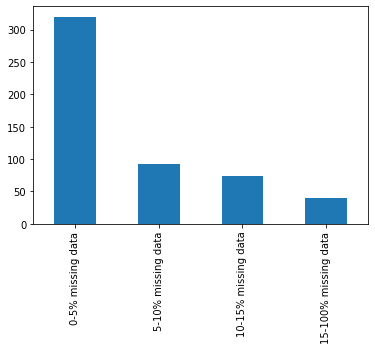

In [173]:
incomplete_clasif.plot(kind='bar')

### Análisis y posibles soluciones ```only_reading_creciente```

In [177]:
for i in dict_contadores['only_reading_creciente']:
    print(i, (len(df[df['ID']==i]))/(24*365-1)*100)

26 73.54720858545495
33 93.74357803402215
34 73.54720858545495
35 72.99920082201164
37 65.11017239410891
54 73.82121246717662
62 96.03836054344103
64 91.23187578490696
74 72.1657723484416
85 85.34079232789131
112 98.76698253225254
113 88.90284279027286
116 22.833656810138145
135 73.0106176504167
145 74.09521634889828
159 88.85717547665259
185 85.30654184267611
192 72.97636716520151
193 72.21143966206188
199 72.99920082201164
203 72.21143966206188
210 97.35129581002397
226 95.4903527799977
231 53.70476081744492
233 72.1657723484416
234 73.79837881036649
237 72.96495033679645
242 96.0840278570613
243 74.07238269208814
254 90.82086996232447
261 82.0984130608517
271 98.62998059139171
292 400.20550291129126
293 59.28758990752369
299 88.8914259618678
311 73.5700422422651
313 97.03162461468204
322 74.09521634889828
330 97.3056284964037
347 74.09521634889828
351 82.8405069071812
360 94.93092818814934
371 98.12764014156868
386 98.05913917113826
404 72.18860600525174
406 98.81264984587281
418 71

2565 22.365566845530314
2566 48.07626441374586
2567 41.28325151272976
2568 28.873159036419683
2569 16.98824066674278
2570 20.390455531453362
2571 35.08391368877726
2574 12.741180500057084
2575 23.75841991094874
2576 48.93252654412604
2578 11.67941545838566
2579 33.32572211439662
2580 6.701678273775545
2582 13.677360429272747
2589 18.175590820869964
2590 34.638657380979566
2591 29.740837995204934
2592 18.164173992464892
2593 23.678502112113257
2594 23.667085283708186
2595 18.141340335654753
2596 18.141340335654753
2597 42.870190661034364
2599 12.752597328462153
2601 41.28325151272976
2602 12.432926133120219
2603 46.706245005137575
2604 15.892225139856148
2606 48.909692887315906
2607 27.514556456216464
2608 48.32743463865738
2610 22.331316360315103
2611 18.175590820869964
2612 6.701678273775545
2613 6.701678273775545
2614 6.701678273775545
2615 28.29090078776116
2616 4.224226509875557
2617 4.224226509875557
2619 18.164173992464892
2620 18.175590820869964
2621 23.68991894051832
2622 31.59

### Análisis y posibles soluciones ```todo_mal```

In [178]:
for i in dict_contadores['todo_mal']:
    print(i, (len(df[df['ID']==i]))/(24*365-1)*100)

23 93.73216120561707
32 82.23541500171252
39 72.2000228336568
72 74.07238269208814
73 96.16394565589678
76 73.79837881036649
78 94.1660006850097
79 82.23541500171252
136 70.23632834798494
138 92.00822011645164
155 74.09521634889828
167 51.01038931384861
206 71.66343189861857
215 98.8583171594931
223 98.72131521863227
241 96.30094759675762
260 97.62529969174564
284 94.6112569928074
312 65.95501769608403
316 73.5700422422651
323 72.98778399360658
325 99.79449708870875
345 77.87418655097615
361 95.06793012901016
414 94.64550747802261
450 71.6520150702135
454 85.52346158237242
457 97.94497088708756
466 98.81264984587281
476 85.00970430414431
478 73.54720858545495
489 72.99920082201164
493 88.12649845872816
514 73.50154127183468
525 71.86893480990982
557 88.86859230505766
565 97.94497088708756
584 98.90398447311337
595 88.90284279027286
615 93.51524146592077
630 74.07238269208814
644 85.35220915629638
654 71.8004338394794
666 95.3876013243521
697 68.48955360200935
700 93.30973855462953
782 

In [181]:
bondad_contadores = {}
for contador in tqdm(df['ID'].unique()):
    rdif0 = df[df['ID']==contador]['READING'].diff().fillna(0).round(4)
    errores = 0
    for (i, rdif) in enumerate(rdif0):
        if rdif < 0:
            errores += 1
    bondad_contadores[contador] = errores/len(rdif0)
    
error_rate = pd.Series(bondad_contadores)
incomplete_clasif = {}
incomplete_clasif['0-5% decreasing READING'] = len(error_rate[error_rate <= 0.05])
incomplete_clasif['5-10% decreasing READING'] = len(error_rate[(error_rate > 0.05) & (error_rate <= 0.1)])
incomplete_clasif['10-15% decreasing READING'] = len(error_rate[(error_rate > 0.1) & (error_rate <= 0.15)])
incomplete_clasif['15-100% decreasing READING'] = len(error_rate[error_rate > 0.15])
incomplete_clasif = pd.Series(incomplete_clasif)
incomplete_clasif

100%|██████████████████████████████████████████████████████████████████████████████| 2747/2747 [01:10<00:00, 39.20it/s]


0-5% decreasing READING       2735
5-10% decreasing READING         6
10-15% decreasing READING        1
15-100% decreasing READING       5
dtype: int64

<AxesSubplot:>

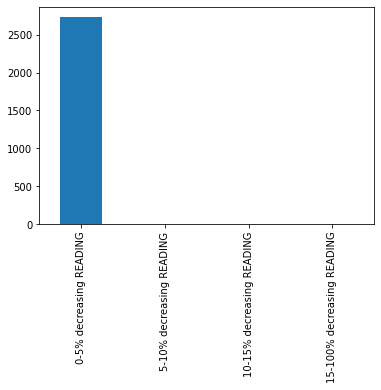

In [182]:
incomplete_clasif.plot(kind='bar')

In [187]:
bondad_contadores = {}
for contador in tqdm(df['ID'].unique()):
    rdif0 = df[df['ID']==contador]['READING'].diff().fillna(0).round(4)
    delta0 = df[df['ID']==contador]['DELTA']
    errores = 0
    for (i, (rdif, delta)) in enumerate(zip(rdif0, delta0)):
        if rdif!=delta:
            errores += 1
    bondad_contadores[contador] = errores/len(delta0)
    
error_rate = pd.Series(bondad_contadores)
incomplete_clasif = {}
incomplete_clasif['0-5% READING.dif()!=DELTA'] = len(error_rate[error_rate <= 0.05])
incomplete_clasif['5-10% READING.dif()!=DELTA'] = len(error_rate[(error_rate > 0.05) & (error_rate <= 0.1)])
incomplete_clasif['10-15% READING.dif()!=DELTA'] = len(error_rate[(error_rate > 0.1) & (error_rate <= 0.15)])
incomplete_clasif['15-100% READING.dif()!=DELTA'] = len(error_rate[error_rate > 0.15])
incomplete_clasif = pd.Series(incomplete_clasif)
incomplete_clasif

100%|██████████████████████████████████████████████████████████████████████████████| 2747/2747 [02:16<00:00, 20.15it/s]


0-5% READING.dif()!=DELTA       1819
5-10% READING.dif()!=DELTA       369
10-15% READING.dif()!=DELTA      236
15-100% READING.dif()!=DELTA     323
dtype: int64

<AxesSubplot:>

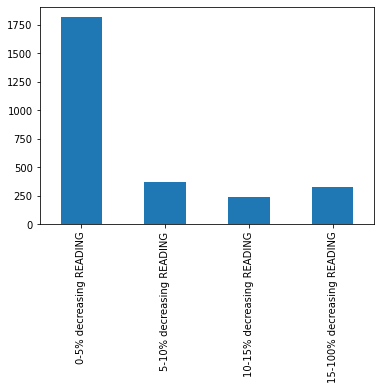

In [186]:
incomplete_clasif.plot(kind='bar')